# pRT direct, 3 params
# Evaluating paul MCMC

In [ ]:
#100k sim- 5 hours  

In [1]:
import time
from petitRADTRANS import Radtrans
import petitRADTRANS.retrieval_examples.emission.master_retrieval_model as rm
from petitRADTRANS import nat_cst as nc
import petitRADTRANS.rebin_give_width as rgw
from scipy.interpolate import interp1d
import sklearn

import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd

from torch.distributions import Independent, Distribution
from fab_priors import BoxUniform_New

import torch
from sbi.inference import SNRE_A, SNRE, prepare_for_sbi, simulate_for_sbi
from sbi.utils.get_nn_models import posterior_nn
from sbi import utils as utils
from sbi.types import Array, OneOrMore, ScalarFloat

#from Simulator import Simulator

In [2]:
retrieval_name = 'JWST_emission_petitRADTRANSpaper'
absolute_path = 'output/'# end with forward slash!
op= '/home/mvasist/petitRADTRANS/petitRADTRANS/retrieval_examples/emission/'
observation_files = {}
observation_files['NIRISS SOSS'] = op +'NIRISS_SOSS_flux.dat'
observation_files['NIRSpec G395M'] = op +'NIRSpec_G395M_flux.dat'
observation_files['MIRI LRS'] = op +'MIRI_LRS_flux.dat'

# Wavelength range of observations, fixed parameters that will not be retrieved
WLEN = [0.3, 15.0]
# LOG_G =  2.58
# R_pl =   1.84*nc.r_jup_mean
R_star = 1.81*nc.r_sun
# Get host star spectrum to calculate F_pl / F_star later.
T_star = 6295.
x = nc.get_PHOENIX_spec(T_star)
fstar = interp1d(x[:,0], x[:,1])

In [3]:
####################################################################################
####################################################################################
### READ IN OBSERVATION
####################################################################################
####################################################################################

# Read in data, convert all to cgs! 

'''
Im using only data_flux_nu_error['MIRI LRS'] from here to calculate the likelihood. 
'''

data_wlen = {}
data_flux_nu = {}
data_flux_nu_error = {}
data_wlen_bins = {}

for name in observation_files.keys():
    print(name)
    dat_obs = np.genfromtxt(observation_files[name])
    data_wlen[name] = dat_obs[:,0]*1e-4
    data_flux_nu[name] = dat_obs[:,1]
    data_flux_nu_error[name] = dat_obs[:,2]
    
    data_wlen_bins[name] = np.zeros_like(data_wlen[name])
    data_wlen_bins[name][:-1] = np.diff(data_wlen[name])
    data_wlen_bins[name][-1] = data_wlen_bins[name][-2]
    

NIRISS SOSS
NIRSpec G395M
MIRI LRS


In [4]:
import pickle as pickle

In [8]:
##reading pickle file

# with open('/home/mvasist/scripts/output/best_position_pre_burn_in_JWST_emission_petitRADTRANSpaper.dat', 'r') as fin:
#     print(pickle.load(fin))
    
fname ='/home/mvasist/samples_paul_MCMC/1/best_position_pre_burn_in_MCMC_200w500it_TintLkIRLg30.dat'
with open(fname, 'rb') as f:
    lines = [x.decode('utf8').strip() for x in f.readlines()]

In [9]:
lines[0]

'[739.71583532  -1.94197358   2.60099785]'

In [10]:
bp_Tint = float((lines[0].split('[')[1]).split(' ')[0])

In [11]:
bp_LkIR = float((lines[0].split('[')[1]).split(' ')[2])

In [12]:
bp_logg= float(((lines[0].split('[')[1]).split(' ')[5]).split(']')[0])

In [13]:
fname1 ='/home/mvasist/samples_paul_MCMC/1/chain_lnprob_MCMC_200w500it_TintLkIRLg30.pickle'
with open(fname1, 'rb') as f:
    lines11 = pickle.load(f)


In [14]:
print(np.shape(lines11))
# print(np.shape(lines12))
# print(np.shape(lines13))


(1, 200, 500)


In [15]:
fname2 ='/home/mvasist/samples_paul_MCMC/1/chain_pos_MCMC_200w500it_TintLkIRLg30.pickle'
with open(fname2, 'rb') as f:
    lines2 = pickle.load(f)
    l3= pickle.load(f)
    l4= pickle.load(f)
    l5= pickle.load(f)

In [16]:
# fname3 ='/home/mvasist/samples_paul_MCMC/chain_pos_JWST_emission_petitRADTRANSpaper_200w500it_LgmTequLg_30.pickle'
# with open(fname3, 'rb') as f:
#     lines23 = pickle.load(f)
#     l33= pickle.load(f)
#     l43= pickle.load(f)
#     l53= pickle.load(f)

In [17]:
l5

array([[662.77218872,  -1.84301338,   4.34707889],
       [662.77218872,  -1.84301338,   4.34707889],
       [662.77218872,  -1.84301338,   4.34707889],
       ...,
       [750.06007557,  -2.00040305,   2.57980781],
       [750.06064783,  -2.00040609,   2.57980883],
       [750.06090727,  -2.00040732,   2.57981012]])

In [18]:
print('pos ',np.shape(lines2))
print('prob ',np.shape(l3))
print('state ', np.shape(l4))
print('samples ',np.shape(l5))


pos  (200, 3)
prob  (200,)
state  (5,)
samples  (100000, 3)


/home/mvasist/anaconda3/envs/petitRT/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [19]:
sampls = l5

In [20]:
samples= sampls.reshape((200,500,3))

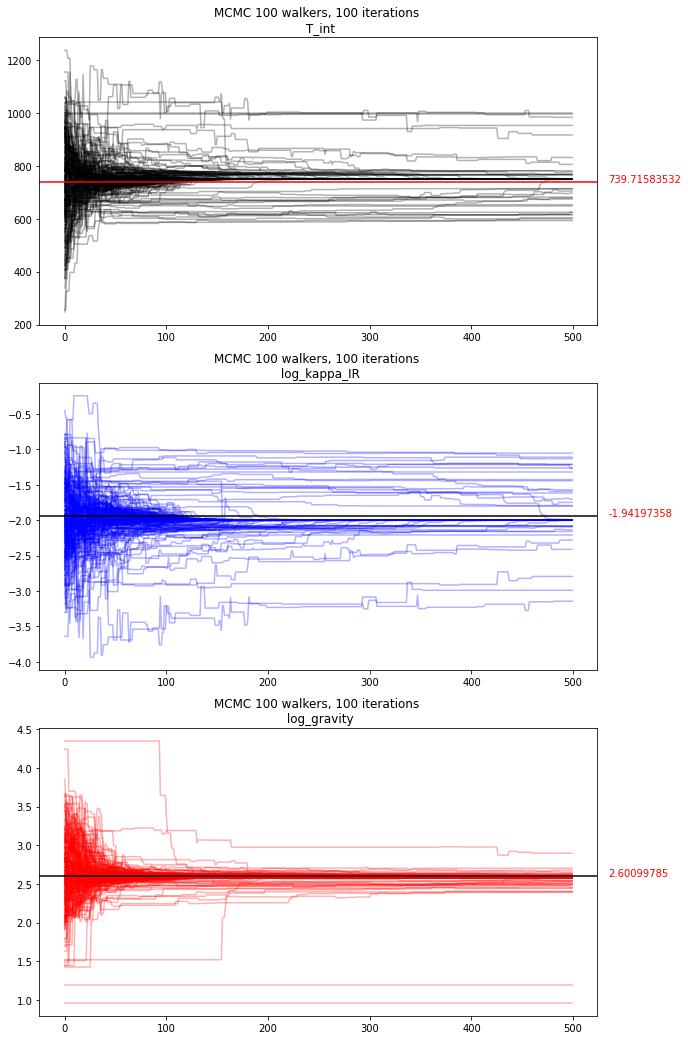

In [22]:
# parameters
f = plt.figure(figsize=(10,18))
ax = f.add_subplot(311)
plt.title('MCMC 100 walkers, 100 iterations \n T_int')
res0= plt.plot(samples[:,:,0].T, '-', color='k', alpha=0.3)
plt.axhline(bp_Tint, color='red')
ax.get_yticklabels()[-1].set_color("red")
plt.text(535 ,bp_Tint,str(bp_Tint),rotation=0, c='red')  #535 for- 500 iterations , 110 - 100 iterations
# plt.show()

ax = f.add_subplot(312)
plt.title('MCMC 100 walkers, 100 iterations \n log_kappa_IR')
res1= ax.plot(samples[:,:,1].T, '-', color='b', alpha=0.3)
ax.axhline(bp_LkIR, color='black')
# res1=ax.set_yticks(ax.get_yticks().tolist())
ax.get_yticklabels()[-1].set_color("red")
plt.text(535,bp_LkIR,str(bp_LkIR),rotation=0, c='red')
# plt.show()

ax = f.add_subplot(313)
plt.title('MCMC 100 walkers, 100 iterations \n log_gravity')
res2= plt.plot(samples[:,:,2].T, '-', color='r', alpha=0.3)
ax.axhline(bp_logg, color='black')
# res2=ax.set_yticks(ax.get_yticks().tolist())
plt.text(535,bp_logg,str(bp_logg),rotation=0, c='red')
plt.show()

In [23]:
import corner

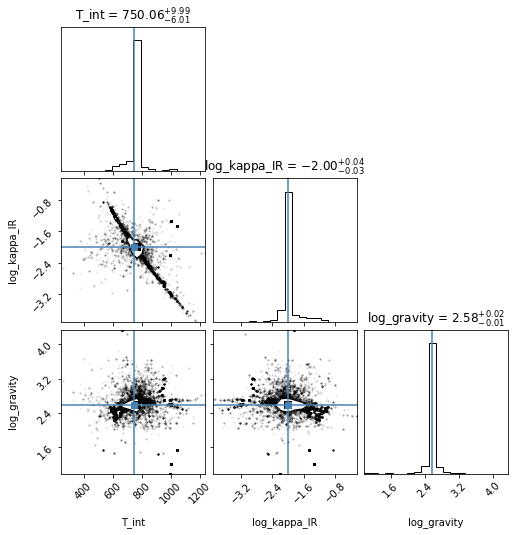

In [25]:
tmp = corner.corner(sampls, labels=['T_int','log_kappa_IR', 'log_gravity'], 
                truths=[750, -2, 2.58], show_titles=True)

# axes.title('240 walkers 50 iterations')